<a href="https://colab.research.google.com/github/MathewBiddle/ioos_by_the_numbers/blob/main/IOOS_BTN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating the IOOS By The Numbers

[Website](https://ioos.noaa.gov/about/ioos-by-the-numbers/)

[Spreadsheet](https://docs.google.com/spreadsheets/d/1AUfXmc3OwxpVdeMNjZyTGWjyR4ku3kRD5eexNrMORnI/edit#gid=516871794)

In [1]:
import pandas as pd

# read previous metrics
ioos_btn_df = pd.read_csv('https://github.com/MathewBiddle/ioos_by_the_numbers/raw/main/ioos_btn_metrics.csv')#columns=['category','value','date'])

In [2]:
import pandas as pd
#today = pd.to_datetime
#ioos_btn_df = pd.DataFrame()#columns=['category','value','date'])

today = pd.Timestamp.strftime(pd.Timestamp.today(tz='UTC'), '%Y-%m-%d')

# only update numbers if it's a new day
if today not in ioos_btn_df['date_UTC'].to_list():
    ioos_btn_df = ioos_btn_df.append({'date_UTC': today}, ignore_index=True)

ioos_btn_df

,date_UTC,Federal Partners,Regional Associations,HF Radar Stations,NGDAC Glider Days,National Platforms,Regional Platforms,ATN Deployments,MBON Projects,OTT Projects,HAB Pilot Projects,QARTOD Manuals,IOOS Core Variables,Metadata Records,IOOS,COMT Projects
0,2018-02-01,17.0,11.0,150.0,52027.0,737.0,335.0,NaN,NaN,NaN,NaN,13.0,34.0,8600.0,1.0,NaN
1,2022-04-22,17.0,11.0,165.0,53672.0,763.0,517.0,4444.0,6.0,8.0,9.0,13.0,34.0,7213.0,1.0,5.0
2,2022-07-08,17.0,11.0,165.0,55448.0,764.0,517.0,4444.0,6.0,8.0,9.0,13.0,34.0,6217.0,1.0,5.0
3,2022-10-05,17.0,11.0,165.0,59088.0,390.0,635.0,4444.0,6.0,8.0,9.0,13.0,34.0,24499.0,1.0,5.0
4,2023-01-05,17.0,11.0,165.0,62042.0,768.0,635.0,4444.0,6.0,8.0,9.0,13.0,34.0,11840.0,1.0,5.0
5,2023-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---
## Federal Partners

ICOOS Act/COORA

In [3]:
fed_partners = 17

# d = {'category':['Federal Partners'],'value':[fed_partners],'date':[today]}

# df_fed_part = pd.DataFrame(d)

ioos_btn_df.loc[ioos_btn_df['date_UTC']==today, ['Federal Partners']] = [fed_partners]

ioos_btn_df

,date_UTC,Federal Partners,Regional Associations,HF Radar Stations,NGDAC Glider Days,National Platforms,Regional Platforms,ATN Deployments,MBON Projects,OTT Projects,HAB Pilot Projects,QARTOD Manuals,IOOS Core Variables,Metadata Records,IOOS,COMT Projects
0,2018-02-01,17.0,11.0,150.0,52027.0,737.0,335.0,NaN,NaN,NaN,NaN,13.0,34.0,8600.0,1.0,NaN
1,2022-04-22,17.0,11.0,165.0,53672.0,763.0,517.0,4444.0,6.0,8.0,9.0,13.0,34.0,7213.0,1.0,5.0
2,2022-07-08,17.0,11.0,165.0,55448.0,764.0,517.0,4444.0,6.0,8.0,9.0,13.0,34.0,6217.0,1.0,5.0
3,2022-10-05,17.0,11.0,165.0,59088.0,390.0,635.0,4444.0,6.0,8.0,9.0,13.0,34.0,24499.0,1.0,5.0
4,2023-01-05,17.0,11.0,165.0,62042.0,768.0,635.0,4444.0,6.0,8.0,9.0,13.0,34.0,11840.0,1.0,5.0
5,2023-02-01,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---
## Regional Associations

In [4]:
import requests
from bs4 import BeautifulSoup
import re

regional_associations = 0

url = 'https://ioos.noaa.gov/regions/regions-at-a-glance/'

headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36'}

html = requests.get(url, headers=headers).text

soup = BeautifulSoup(html, 'html.parser')

for tag in soup.find_all('a'):

  if tag.find("strong") is not None:

     print(tag.find("strong").text)

     regional_associations+=1

print("\nNumber of Regional Associations:", regional_associations)

ioos_btn_df.loc[ioos_btn_df['date_UTC']==today, ['Regional Associations']] = [regional_associations]

ioos_btn_df

Alaska Ocean Observing System (AOOS)
Caribbean Coastal Ocean Observing System (CARICOOS)
Central and Northern California Ocean Observing System (CeNCOOS)
Gulf of Mexico Coastal Ocean Observing System (GCOOS)
Great Lakes Observing System (GLOS)
Mid-Atlantic Coastal Ocean Observing System (MARACOOS)
Northwest Association of Networked Ocean Observing Systems (NANOOS)
Northeastern Regional Association of Coastal Ocean Observing Systems (NERACOOS)
Pacific Islands Ocean Observing System (PacIOOS)
Southern California Coastal Ocean Observing System (SCCOOS)
Southeast Coastal Ocean Observing Regional Association (SECOORA)

Number of Regional Associations: 11


,date_UTC,Federal Partners,Regional Associations,HF Radar Stations,NGDAC Glider Days,National Platforms,Regional Platforms,ATN Deployments,MBON Projects,OTT Projects,HAB Pilot Projects,QARTOD Manuals,IOOS Core Variables,Metadata Records,IOOS,COMT Projects
0,2018-02-01,17.0,11.0,150.0,52027.0,737.0,335.0,NaN,NaN,NaN,NaN,13.0,34.0,8600.0,1.0,NaN
1,2022-04-22,17.0,11.0,165.0,53672.0,763.0,517.0,4444.0,6.0,8.0,9.0,13.0,34.0,7213.0,1.0,5.0
2,2022-07-08,17.0,11.0,165.0,55448.0,764.0,517.0,4444.0,6.0,8.0,9.0,13.0,34.0,6217.0,1.0,5.0
3,2022-10-05,17.0,11.0,165.0,59088.0,390.0,635.0,4444.0,6.0,8.0,9.0,13.0,34.0,24499.0,1.0,5.0
4,2023-01-05,17.0,11.0,165.0,62042.0,768.0,635.0,4444.0,6.0,8.0,9.0,13.0,34.0,11840.0,1.0,5.0
5,2023-02-01,17.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---
## Coastal & Ocean Modeling Testbed

The COMT serves as a conduit between the federal operational and research communities and allows sharing of numerical models, observations and software tools. The COMT supports integration, comparison, scientific analyses and archiving of data and model output needed to elucidate, prioritize, and resolve federal and regional operational coastal ocean issues associated with a range of existing and emerging coastal oceanic, hydrologic, and ecological models. The Testbed has enabled significant community building (within the modeling community as well as enhancing academic and federal operational relations) which has dramatically improved model development.

Number of Active Projects via personal communication from COMT program manager.

In [5]:
## COMT website needs to be updated. Once updated this should work

import requests
from bs4 import BeautifulSoup
import re

regional_associations = 0

url = 'https://ioos.noaa.gov/project/comt/'

headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36'}

html = requests.get(url, headers=headers).text

# print(html)

soup = BeautifulSoup(html, 'html.parser')

for tag in soup.find_all('h2'):
  if tag.text == 'Current Projects':
    comt = len(tag.next_sibling.find_all('li'))
    
print('COMT Projects:',comt) 

ioos_btn_df.loc[ioos_btn_df['date_UTC']==today, ['COMT Projects']] = comt

ioos_btn_df

COMT Projects: 5


,date_UTC,Federal Partners,Regional Associations,HF Radar Stations,NGDAC Glider Days,National Platforms,Regional Platforms,ATN Deployments,MBON Projects,OTT Projects,HAB Pilot Projects,QARTOD Manuals,IOOS Core Variables,Metadata Records,IOOS,COMT Projects
0,2018-02-01,17.0,11.0,150.0,52027.0,737.0,335.0,NaN,NaN,NaN,NaN,13.0,34.0,8600.0,1.0,NaN
1,2022-04-22,17.0,11.0,165.0,53672.0,763.0,517.0,4444.0,6.0,8.0,9.0,13.0,34.0,7213.0,1.0,5.0
2,2022-07-08,17.0,11.0,165.0,55448.0,764.0,517.0,4444.0,6.0,8.0,9.0,13.0,34.0,6217.0,1.0,5.0
3,2022-10-05,17.0,11.0,165.0,59088.0,390.0,635.0,4444.0,6.0,8.0,9.0,13.0,34.0,24499.0,1.0,5.0
4,2023-01-05,17.0,11.0,165.0,62042.0,768.0,635.0,4444.0,6.0,8.0,9.0,13.0,34.0,11840.0,1.0,5.0
5,2023-02-01,17.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0


---
## HF Radar Installations

The previous number of 181 included all locations where a HFR station had ever been sighted as part of the IOOS National Network, but doesn't appear to me to have accounted for temporary installations, HFRs unfunded by IOOS operated by international partners, or instances where an HFR being relocated from one site to another caused it to be double-counted.  Even the number 165 represents a "high water mark" for simultaneously operating HFRs, since HFRs routinely are taken offline for periods of time, for both planned preventative maintenance and in response to other exigent issues.

From http://hfrnet.ucsd.edu/sitediag/stationList.php

In [6]:
# url = 'http://hfrnet.ucsd.edu/sitediag/stationList.php?output=CSV'

# df_hfr = pd.read_csv(url)

# hfr_installations = df_hfr['Station'].unique().size

# print('HF Radar Installations:',hfr_installations)

hfr_installations = 165

ioos_btn_df.loc[ioos_btn_df['date_UTC']==today, ['HF Radar Stations']] = hfr_installations

ioos_btn_df

,date_UTC,Federal Partners,Regional Associations,HF Radar Stations,NGDAC Glider Days,National Platforms,Regional Platforms,ATN Deployments,MBON Projects,OTT Projects,HAB Pilot Projects,QARTOD Manuals,IOOS Core Variables,Metadata Records,IOOS,COMT Projects
0,2018-02-01,17.0,11.0,150.0,52027.0,737.0,335.0,NaN,NaN,NaN,NaN,13.0,34.0,8600.0,1.0,NaN
1,2022-04-22,17.0,11.0,165.0,53672.0,763.0,517.0,4444.0,6.0,8.0,9.0,13.0,34.0,7213.0,1.0,5.0
2,2022-07-08,17.0,11.0,165.0,55448.0,764.0,517.0,4444.0,6.0,8.0,9.0,13.0,34.0,6217.0,1.0,5.0
3,2022-10-05,17.0,11.0,165.0,59088.0,390.0,635.0,4444.0,6.0,8.0,9.0,13.0,34.0,24499.0,1.0,5.0
4,2023-01-05,17.0,11.0,165.0,62042.0,768.0,635.0,4444.0,6.0,8.0,9.0,13.0,34.0,11840.0,1.0,5.0
5,2023-02-01,17.0,11.0,165.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0


---
## NGDAC Glider Days
Gliders monitor water currents, temperature, and conditions that reveal effects from storms, impacts on fisheries, and the quality of our water. This information creates a more complete picture of what is happening in the ocean, as well as trends scientists might be able to detect. U.S. IOOS began counting “Glider days” in 2008 with the intent to better coordinate across U.S. glider operations and to increase the data sharing and data management of this technology. One "Glider Day" is defined as 1 glider in the water collecting data for 1 day.

From https://gliders.ioos.us/erddap/info/index.html?page=1&itemsPerPage=1000

Cumulative from 2008 - present

### Conditions on our calculations:
* drops all datasets with `datasetID` containing `delayed`.
* duration is calculated based on the metadata ERDDAP generates.
  * If a datum of `NaN` is in the `time` variable, the min/max will not be computed.

### Checks

[gist 1](https://nbviewer.org/urls/gist.githubusercontent.com/ocefpaf/e1e6f341c4149ff1d7b6541635d599fb/raw/f79b40741ed96672c025eaff9cbf87d7287b06f3/compute_gliders_days.ipynb)

This one fetches individual info dataset_ids URLs and matches what you are doing with allDatasets. It is still much bigger than `gdutils`, not sure what else it is filtering.

This is too slow (~20 mins), it only serves to double check this computation and to figure out how many gliders we are throwing away due to bad metadata, in this case, 1 `Nemesis-20170512T0000`. 

[gist 2](https://nbviewer.org/urls/gist.githubusercontent.com/ocefpaf/97b943abaa1490701cd386741fabeb56/raw/9628c27b678fbfd678c80195869112e64e32c5ad/compute_gliders_days-time-var.ipynb)

This one is a similar approach but with the time variable instead. We drop the NaN in the time var, so we do include most of `Nemesis-20170512T0000`. Note that it is larger, but not by much, than just the inclusion of `Nemesis-20170512T0000` and that is probably because the metadata is wrong in a few places. 

In theory the last one is more accurate but the difference is small.


In [7]:
# import pandas as pd
# df_glider = pd.read_csv('https://gliders.ioos.us/erddap/tabledap/allDatasets.csvp?minTime%2CmaxTime%2CdatasetID')
# df_glider.dropna(
#     axis=0, 
#     inplace=True,
#     )

# # drop delayed datasets
# df_glider = df_glider[df_glider["datasetID"].str.contains("delayed")==False]

# df_glider[['minTime (UTC)','maxTime (UTC)']] = df_glider[
#                                                          ['minTime (UTC)','maxTime (UTC)']
#                                                          ].apply(pd.to_datetime)

# df_glider['glider_days'] = (df_glider['maxTime (UTC)'] - df_glider['minTime (UTC)']).dt.days

# glider_days = df_glider['glider_days'].sum()

# print('Cumulative glider days:', glider_days)

# ioos_btn_df.loc[ioos_btn_df['date_UTC']==today, ['NGDAC Glider Days']] = glider_days

# ioos_btn_df

Gliders picking a time period.

In [8]:
import pandas as pd
df_glider = pd.read_csv('https://gliders.ioos.us/erddap/tabledap/allDatasets.csvp?minTime%2CmaxTime%2CdatasetID')
df_glider.dropna(
    axis=0, 
    inplace=True,
    )

# drop delayed datasets
df_glider = df_glider[df_glider["datasetID"].str.contains("delayed")==False]

df_glider[['minTime (UTC)','maxTime (UTC)']] = df_glider[
                                                         ['minTime (UTC)','maxTime (UTC)']
                                                         ].apply(pd.to_datetime)

start_date = '2000-01-01'
end_date = '2022-12-31'

# find glider deployments between 10/01 and 12/31
glider_day_within = df_glider.loc[
    (df_glider['minTime (UTC)'] > pd.to_datetime(start_date,utc=True)) &
    (df_glider['maxTime (UTC)'] < pd.to_datetime(end_date,utc=True))
]

# gliders that start before 10/01 and end after 12/31
glider_day_outside = df_glider.loc[
    (df_glider['minTime (UTC)'] < pd.to_datetime(start_date,utc=True)) &
    (df_glider['maxTime (UTC)'] > pd.to_datetime(end_date,utc=True))
]

glider_day_outside.loc[:, 'maxTime (UTC)'] = pd.to_datetime(end_date, utc=True)
glider_day_outside.loc[:, 'minTime (UTC)'] = pd.to_datetime(start_date, utc=True)

# drop the ones from above as they will be duplicates in the next round of filtering
df_glider.drop(axis=0, index=glider_day_outside.index, inplace=True)

# Find gliders that start before 10/01 and end after 10/01
glider_day_lower = df_glider.loc[
    (df_glider['minTime (UTC)'] < pd.to_datetime(start_date,utc=True)) &
    (df_glider['maxTime (UTC)'] > pd.to_datetime(start_date,utc=True))
]

glider_day_lower.loc[:,'minTime (UTC)'] = pd.to_datetime(start_date, utc=True)

# Find gliders that start before 12/31 and end after 12/31.
glider_day_upper = df_glider.loc[
    (df_glider['minTime (UTC)']<pd.to_datetime(end_date,utc=True)) &
    (df_glider['maxTime (UTC)']>pd.to_datetime(end_date,utc=True))
]

glider_day_upper.loc[:,'maxTime (UTC)'] = pd.to_datetime(end_date, utc=True)

# Combine it all together into one DF.
glider_subset = pd.concat([glider_day_lower, 
                           glider_day_within, 
                           glider_day_upper, 
                           glider_day_outside], 
                          verify_integrity=True)

# Calculate the days between min time and max time.
glider_subset['glider_days'] = (glider_subset['maxTime (UTC)'] - glider_subset['minTime (UTC)']).dt.days

# Calculate total glider days.
glider_days = glider_subset['glider_days'].sum()

print("Glider days between %s and %s: %s" % (start_date,end_date,glider_days))

ioos_btn_df.loc[ioos_btn_df['date_UTC']==today, ['NGDAC Glider Days']] = glider_days

ioos_btn_df

Glider days between 2000-01-01 and 2022-12-31: 61990


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,date_UTC,Federal Partners,Regional Associations,HF Radar Stations,NGDAC Glider Days,National Platforms,Regional Platforms,ATN Deployments,MBON Projects,OTT Projects,HAB Pilot Projects,QARTOD Manuals,IOOS Core Variables,Metadata Records,IOOS,COMT Projects
0,2018-02-01,17.0,11.0,150.0,52027.0,737.0,335.0,NaN,NaN,NaN,NaN,13.0,34.0,8600.0,1.0,NaN
1,2022-04-22,17.0,11.0,165.0,53672.0,763.0,517.0,4444.0,6.0,8.0,9.0,13.0,34.0,7213.0,1.0,5.0
2,2022-07-08,17.0,11.0,165.0,55448.0,764.0,517.0,4444.0,6.0,8.0,9.0,13.0,34.0,6217.0,1.0,5.0
3,2022-10-05,17.0,11.0,165.0,59088.0,390.0,635.0,4444.0,6.0,8.0,9.0,13.0,34.0,24499.0,1.0,5.0
4,2023-01-05,17.0,11.0,165.0,62042.0,768.0,635.0,4444.0,6.0,8.0,9.0,13.0,34.0,11840.0,1.0,5.0
5,2023-02-01,17.0,11.0,165.0,61990.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0


Kathy's glider code

In [9]:
# import ipydatetime
# from datetime import datetime
# from ipywidgets import VBox, HBox, Label, BoundedFloatText


# dt0 = ipydatetime.NaiveDatetimePicker(value=datetime(2000, 1, 1, 0, 0, 0), description='start time:')
# dt1 = ipydatetime.NaiveDatetimePicker(value=datetime(2022, 12, 31, 23, 59, 59), description='end time:')

# south = BoundedFloatText(
#     value=-90,
#     min=-90,
#     max=90,
#     description='min lat:',
# )

# north = BoundedFloatText(
#     value=90,
#     min=-90,
#     max=90,
#     description='max lat:',
# )


# west = BoundedFloatText(
#     value=-180,
#     min=-180,
#     max=180,
#     description='min lon:',
# )

# east = BoundedFloatText(
#     value=180,
#     min=-180,
#     max=180,
#     description='max lon:',
# )

# from ipywidgets import Layout, Button, Box


# box_layout = Layout(
#     display="flex",
#     flex_flow="column",
#     align_items="center"
# )

# items = [
#     VBox([dt0, dt1]),
#     north,
#     HBox([west, east]),
#     south,
# ]

# box = Box(children=items, layout=box_layout)
# box

# dt0 = dt0.value
# dt1 = dt1.value
# south = south.value
# north = north.value
# west = west.value
# east = east.value
        
# params = {
#     "min_time": dt0,
#     "max_time": dt1,
#     "min_lat": south,
#     "max_lat": north,
#     "min_lon": west,
#     "max_lon": east,
# }

# from gdutils import GdacClient


# client = GdacClient()

# client.search_datasets(params=params, include_delayed_mode=False)
# client.datasets

# # Count the total number of deployments within the dt0:dt1 time window
# num_deployments = client.datasets.shape[0]

# # Count the number of glider days within the dt0:dt1 time window
# glider_days = client.glider_days_per_yyyymmdd.loc[dt0:dt1].sum()

# # count the number of profiles per dataset
# profile_count = client.profiles_per_yyyymmdd.loc[dt0:dt1].sum()

# datasets = client.datasets.copy()

# import warnings


# sea_names = []
# funding_sources = []
# for dataset_id, row in datasets.iterrows():

#     # Fetch the dataset description from ERDDAP
#     info = client.get_dataset_metadata(dataset_id)

#     if info.empty:
#         continue

#     # Find all global NetCDF attributes
#     nc_globals = info.loc[info["Variable Name"] == "NC_GLOBAL"]

#     # Find the sea_name global attribute
#     sea_name_attr = nc_globals.loc[nc_globals["Attribute Name"] == "sea_name"]
#     sea_name = "unknown"
#     if not sea_name_attr.empty:
#         sea_name = sea_name_attr.Value.iloc[0]
#         sea_name = sea_name or "unknown"
#     else:
#         warnings.warn(f"{dataset_id}: sea_name NC_GLOBAL not found")

#     # Find all global attributes that begin with "acknowledg" as this attribute typically contains the funding sources
#     funding_attr = nc_globals.loc[nc_globals["Attribute Name"].str.startswith("acknowledg")]
#     funding = "unknown"
#     if not funding_attr.empty:
#         funding = funding_attr.Value.iloc[0]
#         funding = funding or "unknown"
#     else:
#         warnings.warn(f"{dataset_id}: acknowledgment NC_GLOBAL not found")

#     sea_names.append(sea_name)
#     funding_sources.append(funding)

#     # Count only the days and profiles that are dt0:dt1 inclusive
#     days = client.datasets_days[dataset_id].loc[dt0:dt1].sum()
#     profiles = client.datasets_profiles[dataset_id].loc[dt0:dt1].sum()
#     datasets.loc[dataset_id, ("days", "num_profiles")] = [days, profiles]


# print(f"time ranged from {dt0} to {dt1}")
# print(f"""
# {num_deployments = }
# {glider_days = }
# {profile_count = }
# """
# )

---
## National Platforms

The National backbone of IOOS includes buoys, water level gauges,as well as coastal and estuary stations run by our federal partners. Platforms calculated within this total are assets within the EEZ. For buoys this includes platforms managed by NOAA's National Data Buoy Center, the NOAA NMFS Chesapeake Bay Interpretive Buoy System (CBIBS), and the U.S. Army Corps of Engineers’ Coastal Data Information Program (CDIP), Ocean Acidification Program , Ecosystems and Fishery Oceanography Coordinated Investigations (EcoFOCI). For guages, this includes National Water Level Observation Network guages operated by the Center for Operational Oceanographic Products and Services (CO-OPS). The coastal and estuary stations are maintained through NOAA's National Estuarine Research Reserves (NERR) System-Wide Management Program (SWMP).

### CO-OPS
* https://opendap.co-ops.nos.noaa.gov/stations/index.jsp
  * as xml: https://opendap.co-ops.nos.noaa.gov/stations/stationsXML.jsp
* https://tidesandcurrents.noaa.gov/cdata/StationList?type=Current+Data&filter=active

In [10]:
#from lxml import etree
import requests
import pandas as pd

xml = requests.get('https://opendap.co-ops.nos.noaa.gov/stations/stationsXML.jsp').text
import re
COOPS = sum(1 for _ in re.finditer(r'\b%s\b' % re.escape("station name"), xml))
print("All stations:",COOPS)

url = 'https://tidesandcurrents.noaa.gov/cdata/StationListFormat?type=Current+Data&filter=active&format=csv'

df_coops = pd.read_csv(url)
#print(df_coops[' Project'].unique())
ports = df_coops[df_coops[' Project'].astype(str).str.contains('PORTS')].shape[0]
print("Ports:", ports)

All stations: 375
Ports: 70


### NDBC
https://www.ndbc.noaa.gov/wstat.shtml	Buoys: 106 (103 base-funded); CMAN: 45

In [11]:
import requests
from bs4 import BeautifulSoup
import re
import pprint

url = 'https://www.ndbc.noaa.gov/wstat.shtml'

headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36'}

html = requests.get(url, headers=headers).text

soup = BeautifulSoup(html, 'html.parser')

string_to_find = ['Total Base Funded Buoys:','Total Other Buoys:',
                  'Total Moored Buoys:','Total Base Funded Stations:',
                  'Total Stations:']

ndbc = dict()
for string in string_to_find:
    for tag in soup.find_all("td", string=string):
        ndbc[string] = int(tag.next_sibling.string)

#pprint.pprint(ndbc)

NDBC = ndbc['Total Moored Buoys:'] + ndbc['Total Base Funded Stations:']
print('NDBC:',NDBC)

NDBC: 149


### NERRS
https://nosc.noaa.gov/OSC/OSN/index.php	NERRS SWMP; Across 29 NERRS; Source = internal access only - NOAA Observing System Council.

http://cdmo.baruch.sc.edu/webservices.cfm <- need IP address approval

Need number of stations (120 last time)

In [12]:
# try:
#   from suds.client import Client
# except:
#   !pip install suds
#   from suds.client import Client

# soapClient = Client("http://cdmo.baruch.sc.edu/webservices2/requests.cfc?wsdl", timeout=90, retxml=True)

# #Get the station codes SOAP request example.
# station_codes = soapClient.service.exportStationCodesXML()
# print(station_codes)

In [13]:

import requests
from bs4 import BeautifulSoup
import re

url = 'https://coast.noaa.gov/nerrs/about/'

headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36'}

html = requests.get(url,headers=headers).text

soup = BeautifulSoup(html, 'html.parser')

string_to_find = ['The National Estuarine Research Reserve System is a network of ']

nerrs = dict()
for string in string_to_find:
  for tag in soup.find_all("meta", attrs={'content': re.compile(string)}, limit=1):
    res = [int(i) for i in tag['content'].split() if i.isdigit()] # extract number
    #print(tag['content'])
    NERRS = int(res[0])
    #print('%s = %s' % (string, tag.next_sibling.string))

#NERRS = 140

print("NERRS reserves:",NERRS)


NERRS reserves: 30


### CBIBS
https://buoybay.noaa.gov/locations

[API docs](https://buoybay.noaa.gov/node/174)

Base URL: https://mw.buoybay.noaa.gov/api/v1

Testing Key: f159959c117f473477edbdf3245cc2a4831ac61f

Latest measurements:
https://mw.buoybay.noaa.gov/api/v1/json/station?key=f159959c117f473477edbdf3245cc2a4831ac61f

In [14]:
import json

base_url = 'https://mw.buoybay.noaa.gov/api/v1'
apikey = 'f159959c117f473477edbdf3245cc2a4831ac61f'
start = '2021-12-08T01:00:00z'
end = '2021-12-09T23:59:59z'
var = 'Position'

query_url = '{}/json/query?key={}&sd={}&ed={}&var={}'.format(base_url,apikey,start,end,var)
#query_url = '{}/json/station?key={}'.format(base_url, apikey)

json = json.loads(requests.get(query_url).text)

CBIBS = len(json['stations'])

print("CBIBS Stations:",CBIBS)

CBIBS Stations: 12


### OAP
https://cdip.ucsd.edu/m/stn_table/	Includes overlap with the RAs and other programs

19

See buoys and moorings at https://oceanacidification.noaa.gov/WhatWeDo/Data.aspx

pull kml from pmel

In [15]:
# import geopandas as gpd
# import fiona

# gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'

# kml = 'https://www.pmel.noaa.gov/co2/files/basekml.kml'

# df = gpd.read_file(kml, driver='KML')

# df['Name'].unique().size

In [16]:
import requests
from bs4 import BeautifulSoup
import re

url = 'https://oceanacidification.noaa.gov/WhatWeDo/Data.aspx'

#url = 'https://www.arcgis.com/apps/Embed/index.html?webmap=9512aae84cae409786339479e31b6c8a&amp;extent=-152.4023,-57.7072,146.7773,74.4006&amp;zoom=true&amp;scale=true&amp;disable_scroll=true&amp;theme=light'

html = requests.get(url).text

soup = BeautifulSoup(html, 'html.parser')

text = soup.find_all(attrs={'id':"dnn_ctr14711_ContentPane"})[0].find_all(attrs={'class':'lead'})[0].text #id="mapDiv")

res = [int(i) for i in text.split() if i.isdigit()] # extract number
    #print(tag['content'])
OAP = int(res[0])

print("OAP Stations:",OAP)

OAP Stations: 19


### CDIP
https://cdip.ucsd.edu/m/stn_table/	Includes overlap with the RAs

67

https://cdip.ucsd.edu/themes/?d2=p1:m:mobile&regions=all&units=standard&zoom=auto&pub_set=public&tz=UTC&ll_fmt=dm&numcolorbands=10&palette=cdip_classic&high=6.096

In [17]:
import lxml
import pandas as pd

url = 'https://cdip.ucsd.edu/themes/?d2=p1:m:mobile&regions=all&units=standard&zoom=auto&pub_set=public&tz=UTC&ll_fmt=dm&numcolorbands=10&palette=cdip_classic&high=6.096'
#url = 'https://cdip.ucsd.edu/m/stn_table/'
table_list = pd.read_html(url, match='Stn')

df = table_list[0]

CDIP = df['Stn'].unique().size

print("CDIP Stations:",CDIP)

CDIP Stations: 71


### Calculating National Platforms

from 2018: CO-OPS + NDBC + NERRS + CBIBS + OAP + CDIP = 747

In [18]:
national_platforms = COOPS + NDBC + NERRS + CBIBS + OAP + CDIP
print("National Platforms:",national_platforms)

ioos_btn_df.loc[ioos_btn_df['date_UTC']==today, ['National Platforms']] = national_platforms

ioos_btn_df

National Platforms: 656


,date_UTC,Federal Partners,Regional Associations,HF Radar Stations,NGDAC Glider Days,National Platforms,Regional Platforms,ATN Deployments,MBON Projects,OTT Projects,HAB Pilot Projects,QARTOD Manuals,IOOS Core Variables,Metadata Records,IOOS,COMT Projects
0,2018-02-01,17.0,11.0,150.0,52027.0,737.0,335.0,NaN,NaN,NaN,NaN,13.0,34.0,8600.0,1.0,NaN
1,2022-04-22,17.0,11.0,165.0,53672.0,763.0,517.0,4444.0,6.0,8.0,9.0,13.0,34.0,7213.0,1.0,5.0
2,2022-07-08,17.0,11.0,165.0,55448.0,764.0,517.0,4444.0,6.0,8.0,9.0,13.0,34.0,6217.0,1.0,5.0
3,2022-10-05,17.0,11.0,165.0,59088.0,390.0,635.0,4444.0,6.0,8.0,9.0,13.0,34.0,24499.0,1.0,5.0
4,2023-01-05,17.0,11.0,165.0,62042.0,768.0,635.0,4444.0,6.0,8.0,9.0,13.0,34.0,11840.0,1.0,5.0
5,2023-02-01,17.0,11.0,165.0,61990.0,656.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0


---
## Regional Platforms

Regional platforms are calculated from the annual IOOS asset inventory submitted by each Regional Association. More information about the IOOS asset inventory can be found at https://github.com/ioos/ioos-asset-inventory

The data from 2020 can be found [here](https://github.com/ioos/ioos-asset-inventory/tree/main/2020) and is available on [ERDDAP](http://erddap.ioos.us/erddap/tabledap/processed_asset_inventory.html).

In [19]:
url = 'http://erddap.ioos.us/erddap/tabledap/processed_asset_inventory.csvp'

df_regional_platforms = pd.read_csv(url)

regional_platforms = df_regional_platforms['station_long_name'].unique().size

print('Regional platforms:',regional_platforms)

ioos_btn_df.loc[ioos_btn_df['date_UTC']==today, ['Regional Platforms']] = regional_platforms

ioos_btn_df

Regional platforms: 635


,date_UTC,Federal Partners,Regional Associations,HF Radar Stations,NGDAC Glider Days,National Platforms,Regional Platforms,ATN Deployments,MBON Projects,OTT Projects,HAB Pilot Projects,QARTOD Manuals,IOOS Core Variables,Metadata Records,IOOS,COMT Projects
0,2018-02-01,17.0,11.0,150.0,52027.0,737.0,335.0,NaN,NaN,NaN,NaN,13.0,34.0,8600.0,1.0,NaN
1,2022-04-22,17.0,11.0,165.0,53672.0,763.0,517.0,4444.0,6.0,8.0,9.0,13.0,34.0,7213.0,1.0,5.0
2,2022-07-08,17.0,11.0,165.0,55448.0,764.0,517.0,4444.0,6.0,8.0,9.0,13.0,34.0,6217.0,1.0,5.0
3,2022-10-05,17.0,11.0,165.0,59088.0,390.0,635.0,4444.0,6.0,8.0,9.0,13.0,34.0,24499.0,1.0,5.0
4,2023-01-05,17.0,11.0,165.0,62042.0,768.0,635.0,4444.0,6.0,8.0,9.0,13.0,34.0,11840.0,1.0,5.0
5,2023-02-01,17.0,11.0,165.0,61990.0,656.0,635.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0


---
## ATN Deployments

See Deployments at https://portal.atn.ioos.us/#
Not sure if there is a way to scrape that page or get those values from somewhere

4242

In [20]:
#!pip install gekodriver

In [21]:
## super broken!

# # stuff to get selenium working
# !pip install selenium
# !apt-get update # to update ubuntu to correctly run apt install
# !apt install chromium-chromedriver
# !cp /usr/lib/chromium-browser/chromedriver /usr/bin
# import sys
# sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

# # onto the code
# from selenium import webdriver
# chrome_options = webdriver.ChromeOptions()
# chrome_options.add_argument('--headless')
# chrome_options.add_argument('--no-sandbox')
# chrome_options.add_argument('--disable-dev-shm-usage')

# wd = webdriver.Chrome('chromedriver',options=chrome_options)

# wd.get("https://portal.atn.ioos.us/#")

# atn_deployments = wd.find_elements(By.XPATH, "//p[@class='val']")[-1].text

# atn_deployments = 4639

# print("ATN Deployments:",atn_deployments)

# ioos_btn_df.loc[ioos_btn_df['date_UTC']==today, ['ATN Deployments']] = atn_deployments

# ioos_btn_df

In [22]:
atn_deployments = 4639

print("ATN Deployments:",atn_deployments)

ioos_btn_df.loc[ioos_btn_df['date_UTC']==today, ['ATN Deployments']] = atn_deployments

ioos_btn_df

ATN Deployments: 4639


,date_UTC,Federal Partners,Regional Associations,HF Radar Stations,NGDAC Glider Days,National Platforms,Regional Platforms,ATN Deployments,MBON Projects,OTT Projects,HAB Pilot Projects,QARTOD Manuals,IOOS Core Variables,Metadata Records,IOOS,COMT Projects
0,2018-02-01,17.0,11.0,150.0,52027.0,737.0,335.0,NaN,NaN,NaN,NaN,13.0,34.0,8600.0,1.0,NaN
1,2022-04-22,17.0,11.0,165.0,53672.0,763.0,517.0,4444.0,6.0,8.0,9.0,13.0,34.0,7213.0,1.0,5.0
2,2022-07-08,17.0,11.0,165.0,55448.0,764.0,517.0,4444.0,6.0,8.0,9.0,13.0,34.0,6217.0,1.0,5.0
3,2022-10-05,17.0,11.0,165.0,59088.0,390.0,635.0,4444.0,6.0,8.0,9.0,13.0,34.0,24499.0,1.0,5.0
4,2023-01-05,17.0,11.0,165.0,62042.0,768.0,635.0,4444.0,6.0,8.0,9.0,13.0,34.0,11840.0,1.0,5.0
5,2023-02-01,17.0,11.0,165.0,61990.0,656.0,635.0,4639.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0


---
## MBON Projects
Living marine resources are essential to the health and recreational needs of billions of people, yet marine biodiversity and ecosystem processes remain major frontiers in ocean observing. IOOS has a critical role in implementing operational, sustained programs to observe biology and catalogue biodiversity to ensure these data are available for science, management, and the public. IOOS is leading development of the Marine Biodiversity Observation Network, with core funding from NOAA, NASA and BOEM. MBON connects regional networks of scientists, resource managers, and users and integrates data from existing long-term programs to understand human- and climate-induced change and its impacts on marine life. MBON partners are pioneering application of new remote sensing methods, imaging, molecular approaches (eDNA and ‘omics), and other technologies and integrating these with traditional research methods and coordinated experiments to understand changing patterns of biodiversity.

These are the currently funded MBON projects. At this time, we are manually checking https://marinebon.org/ and counting the number of U.S. projects.

We hope to be able to use the resources [here](https://github.com/marinebon/www_marinebon2/tree/master/content/project) to automatically harvest these metrics in the future.

For 2022 the currently funded projects = 6

In [23]:
## BROKEN

import requests
from bs4 import BeautifulSoup
import re

regional_associations = 0

url = 'https://ioos.noaa.gov/project/mbon/'

headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36'}

html = requests.get(url, headers=headers).text

soup = BeautifulSoup(html, 'html.parser')

mbon_projects = 0

for tag in soup.find_all('h3'):
  if 'class' in tag.attrs.keys():
    continue # skipping other headers

  print('PI:\t',tag)
  mbon_projects+=1
#   mbon_projects = len(tag.parent.find_all('li'))

#   for project in tag.parent.find_all('li'):

#     print(project.text)


print("MBON Projects:",mbon_projects)

ioos_btn_df.loc[ioos_btn_df['date_UTC']==today, ['MBON Projects']] = mbon_projects

ioos_btn_df

PI:	 <h3>Francisco Chavez, Monterey Bay Aquarium Research Institute</h3>
PI:	 <h3>Nathan Furey, University of New Hampshire</h3>
PI:	 <h3>Cassandra Glaspie, Louisiana State University</h3>
PI:	 <h3>Katrin Iken, University of Alaska Fairbanks</h3>
PI:	 <h3>Frank Muller-Karger, University of South Florida</h3>
MBON Projects: 5


,date_UTC,Federal Partners,Regional Associations,HF Radar Stations,NGDAC Glider Days,National Platforms,Regional Platforms,ATN Deployments,MBON Projects,OTT Projects,HAB Pilot Projects,QARTOD Manuals,IOOS Core Variables,Metadata Records,IOOS,COMT Projects
0,2018-02-01,17.0,11.0,150.0,52027.0,737.0,335.0,NaN,NaN,NaN,NaN,13.0,34.0,8600.0,1.0,NaN
1,2022-04-22,17.0,11.0,165.0,53672.0,763.0,517.0,4444.0,6.0,8.0,9.0,13.0,34.0,7213.0,1.0,5.0
2,2022-07-08,17.0,11.0,165.0,55448.0,764.0,517.0,4444.0,6.0,8.0,9.0,13.0,34.0,6217.0,1.0,5.0
3,2022-10-05,17.0,11.0,165.0,59088.0,390.0,635.0,4444.0,6.0,8.0,9.0,13.0,34.0,24499.0,1.0,5.0
4,2023-01-05,17.0,11.0,165.0,62042.0,768.0,635.0,4444.0,6.0,8.0,9.0,13.0,34.0,11840.0,1.0,5.0
5,2023-02-01,17.0,11.0,165.0,61990.0,656.0,635.0,4639.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0


## OTT Projects

The IOOS Ocean Technology Transition project sponsors the transition of emerging marine observing technologies, for which there is an existing operational requirement and a demonstrated commitment to integration and use by the ocean observing community, to operational mode. Each year IOOS supports 2-4 projects. The number here reflects the total number projects supported by this effort.

These are the current active OTT projects which was provided by the OTT Program Manager. Hopefully, we can find a good place to harvest these numbers from.

For now, we have the [website](https://ioos.noaa.gov/project/ocean-technology-transition/) and personal communication that there are 8 live projects.

In [24]:
# from bs4 import BeautifulSoup
# import requests
# import pandas as pd

# headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36'}

# url = 'https://ioos.noaa.gov/project/ocean-technology-transition/'

# soup = BeautifulSoup(requests.get(url, headers=headers).text, 'html.parser')

# ott_projects=0

# df = pd.DataFrame()

# for tag in soup.find_all('table'):
#   #for entries in tag.find_all('p'):

#   #print(tag,'\n\n')

#   #print(tag.td)
#   if 'Current Projects' in tag.td.text:
#     for elements in tag.find_all('td'):
#       print(elements,'\n\n')
      
#     #print(tag)
#     #df = pd.read_html(str(tag), header=0, displayed_only=True)
#   #print(str(tag))
#   #df1 = pd.read_html(str(tag),match="Current Projects ")
#   #print(df1,'\n\n')
#   #df = pd.concat([df, df1] )
ott_projects = 8

ioos_btn_df.loc[ioos_btn_df['date_UTC']==today, ['OTT Projects']] = ott_projects

ioos_btn_df

,date_UTC,Federal Partners,Regional Associations,HF Radar Stations,NGDAC Glider Days,National Platforms,Regional Platforms,ATN Deployments,MBON Projects,OTT Projects,HAB Pilot Projects,QARTOD Manuals,IOOS Core Variables,Metadata Records,IOOS,COMT Projects
0,2018-02-01,17.0,11.0,150.0,52027.0,737.0,335.0,NaN,NaN,NaN,NaN,13.0,34.0,8600.0,1.0,NaN
1,2022-04-22,17.0,11.0,165.0,53672.0,763.0,517.0,4444.0,6.0,8.0,9.0,13.0,34.0,7213.0,1.0,5.0
2,2022-07-08,17.0,11.0,165.0,55448.0,764.0,517.0,4444.0,6.0,8.0,9.0,13.0,34.0,6217.0,1.0,5.0
3,2022-10-05,17.0,11.0,165.0,59088.0,390.0,635.0,4444.0,6.0,8.0,9.0,13.0,34.0,24499.0,1.0,5.0
4,2023-01-05,17.0,11.0,165.0,62042.0,768.0,635.0,4444.0,6.0,8.0,9.0,13.0,34.0,11840.0,1.0,5.0
5,2023-02-01,17.0,11.0,165.0,61990.0,656.0,635.0,4639.0,5.0,8.0,NaN,NaN,NaN,NaN,NaN,5.0


## NHABON Pilot Projects

These are the National Harmful Algal Bloom Observing Network Pilot Project awards. Currently these were calculated from the [award announcement pdf](https://cdn.ioos.noaa.gov/media/2021/10/NHABON-Funding-Awards-FY21_v2.pdf) which states that there are 9 total.

Might be able to parse the pdf and calculate this on the fly.

In [25]:
!pip install pdfminer.six

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 71.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 96.3 MB/s eta 0:00:00


In [26]:
from pdfminer.high_level import extract_text

import io

import requests

url = 'https://cdn.ioos.noaa.gov/media/2022/10/NHABON-Funding-Awards-FY22.pdf'

data = requests.get(url)

with io.BytesIO(data.content) as f:
  pdf = extract_text(f)

content = pdf.split('\n')

nhabon_projects = sum("Funded amount" in s for s in content)

nhabon_projects = nhabon_projects + 1 # Gulf of Mexico project

ioos_btn_df.loc[ioos_btn_df['date_UTC']==today, ['HAB Pilot Projects']] = nhabon_projects

ioos_btn_df

,date_UTC,Federal Partners,Regional Associations,HF Radar Stations,NGDAC Glider Days,National Platforms,Regional Platforms,ATN Deployments,MBON Projects,OTT Projects,HAB Pilot Projects,QARTOD Manuals,IOOS Core Variables,Metadata Records,IOOS,COMT Projects
0,2018-02-01,17.0,11.0,150.0,52027.0,737.0,335.0,NaN,NaN,NaN,NaN,13.0,34.0,8600.0,1.0,NaN
1,2022-04-22,17.0,11.0,165.0,53672.0,763.0,517.0,4444.0,6.0,8.0,9.0,13.0,34.0,7213.0,1.0,5.0
2,2022-07-08,17.0,11.0,165.0,55448.0,764.0,517.0,4444.0,6.0,8.0,9.0,13.0,34.0,6217.0,1.0,5.0
3,2022-10-05,17.0,11.0,165.0,59088.0,390.0,635.0,4444.0,6.0,8.0,9.0,13.0,34.0,24499.0,1.0,5.0
4,2023-01-05,17.0,11.0,165.0,62042.0,768.0,635.0,4444.0,6.0,8.0,9.0,13.0,34.0,11840.0,1.0,5.0
5,2023-02-01,17.0,11.0,165.0,61990.0,656.0,635.0,4639.0,5.0,8.0,11.0,NaN,NaN,NaN,NaN,5.0


## QARTOD Manuals

As of the last update there are twelve QARTOD manuals in-place for IOOS. These manuals establish authoritative QA/QC procedures for oceanographic data.

The five year plan lists 16 manuals/papers. There's 13 QC manuals plus the Flags document, the QA paper and the Glider DAC paper. The Glider DAC paper is an implementation plan of the TS QC manual, and it's posted under the Implementation tab on the QARTOD home page, at https://cdn.ioos.noaa.gov/media/2017/12/Manual-for-QC-of-Glider-Data_05_09_16.pdf.


https://ioos.noaa.gov/project/qartod/

In [27]:
from bs4 import BeautifulSoup
import requests

headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36'}

url = 'https://ioos.noaa.gov/project/qartod/'

soup = BeautifulSoup(requests.get(url, headers=headers).text, 'html.parser')

qartod=0

for tag in soup.find_all('li'):

  if "Real-Time Quality Control of" in tag.text:

    print(tag.text)

    qartod+=1

print('QARTOD Manuals:',qartod)

ioos_btn_df.loc[ioos_btn_df['date_UTC']==today, ['QARTOD Manuals']] = qartod

ioos_btn_df

Real-Time Quality Control of pH Data Observations
Real-Time Quality Control of Stream Flow Observations
Real-Time Quality Control of Passive Acoustics Data
Real-Time Quality Control of Phytoplankton Data
Real-Time Quality Control of HF Radar Observations
Real-Time Quality Control of Dissolved Nutrients Observations
Real-Time Quality Control of Wind Data
Real-Time Quality Control of Water Level Data
Real-Time Quality Control of In-Situ Surface Wave Data
Real-Time Quality Control of Ocean Optics Data
Real-Time Quality Control of In-Situ Temperature and Salinity Data
Real-Time Quality Control of Dissolved Oxygen Observations in Coastal Oceans
Real-Time Quality Control of In-Situ Current Observations
QARTOD Manuals: 13


,date_UTC,Federal Partners,Regional Associations,HF Radar Stations,NGDAC Glider Days,National Platforms,Regional Platforms,ATN Deployments,MBON Projects,OTT Projects,HAB Pilot Projects,QARTOD Manuals,IOOS Core Variables,Metadata Records,IOOS,COMT Projects
0,2018-02-01,17.0,11.0,150.0,52027.0,737.0,335.0,NaN,NaN,NaN,NaN,13.0,34.0,8600.0,1.0,NaN
1,2022-04-22,17.0,11.0,165.0,53672.0,763.0,517.0,4444.0,6.0,8.0,9.0,13.0,34.0,7213.0,1.0,5.0
2,2022-07-08,17.0,11.0,165.0,55448.0,764.0,517.0,4444.0,6.0,8.0,9.0,13.0,34.0,6217.0,1.0,5.0
3,2022-10-05,17.0,11.0,165.0,59088.0,390.0,635.0,4444.0,6.0,8.0,9.0,13.0,34.0,24499.0,1.0,5.0
4,2023-01-05,17.0,11.0,165.0,62042.0,768.0,635.0,4444.0,6.0,8.0,9.0,13.0,34.0,11840.0,1.0,5.0
5,2023-02-01,17.0,11.0,165.0,61990.0,656.0,635.0,4639.0,5.0,8.0,11.0,13.0,NaN,NaN,NaN,5.0


## IOOS Core Variables

The IOOS Core Variables are presented on [this website](https://www.iooc.us/task-teams/core-ioos-variables/). For now, this is a hard coded value, but it should be easy to parse that page and count up the variables.

In [28]:
## Broken

# from bs4 import BeautifulSoup
# import requests

# headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36'}

# url = 'https://www.iooc.us/task-teams/core-ioos-variables/'

# soup = BeautifulSoup(requests.get(url, headers=headers).text, 'html.parser')

# text = soup.find(style="color: #808080;").get_text() # grab the sentece w/ the number

# core_vars = [int(i) for i in text.split() if i.isdigit()] # extract number

# print('IOOS Core Variables:',core_vars)

# ioos_btn_df.loc[ioos_btn_df['date_UTC']==today, ['IOOS Core Variables']] = core_vars

# ioos_btn_df

In [29]:
core_vars = 34

ioos_btn_df.loc[ioos_btn_df['date_UTC']==today, ['IOOS Core Variables']] = core_vars

ioos_btn_df

,date_UTC,Federal Partners,Regional Associations,HF Radar Stations,NGDAC Glider Days,National Platforms,Regional Platforms,ATN Deployments,MBON Projects,OTT Projects,HAB Pilot Projects,QARTOD Manuals,IOOS Core Variables,Metadata Records,IOOS,COMT Projects
0,2018-02-01,17.0,11.0,150.0,52027.0,737.0,335.0,NaN,NaN,NaN,NaN,13.0,34.0,8600.0,1.0,NaN
1,2022-04-22,17.0,11.0,165.0,53672.0,763.0,517.0,4444.0,6.0,8.0,9.0,13.0,34.0,7213.0,1.0,5.0
2,2022-07-08,17.0,11.0,165.0,55448.0,764.0,517.0,4444.0,6.0,8.0,9.0,13.0,34.0,6217.0,1.0,5.0
3,2022-10-05,17.0,11.0,165.0,59088.0,390.0,635.0,4444.0,6.0,8.0,9.0,13.0,34.0,24499.0,1.0,5.0
4,2023-01-05,17.0,11.0,165.0,62042.0,768.0,635.0,4444.0,6.0,8.0,9.0,13.0,34.0,11840.0,1.0,5.0
5,2023-02-01,17.0,11.0,165.0,61990.0,656.0,635.0,4639.0,5.0,8.0,11.0,13.0,34.0,NaN,NaN,5.0


---
## Metadata Records
These are the number of metadata records currently available through the [IOOS Catalog](https://data.ioos.us). Previously the number of records was on the order of 8,600. Below are three different mechanisms to calculate this metric, however they do differ and the reason for that difference is unclear. 

https://data.ioos.us/

In [30]:
# Broken

# try:
#   import owslib
# except:
#   %pip install -q owslib

# from owslib.csw import CatalogueServiceWeb

# endpoint = "https://data.ioos.us/csw"

# csw = CatalogueServiceWeb(endpoint, timeout=60)

# csw.getdomain('GetRecords.resultType')

# csw.results

# csw.getrecords2()

# records = csw.results['matches']

# print("Found {} records from {}.".format(records,endpoint))

In [31]:
# Broken

try:
  import ckanapi
except:
  %pip install -q ckanapi

from ckanapi import RemoteCKAN
ua = 'ckanapiioos/1.0 (+https://ioos.us/)'

url = 'https://data.ioos.us'

#ioos_catalog = RemoteCKAN('https://data.ioos.us', user_agent=ua, get_only=True)
ioos_catalog = RemoteCKAN(url, user_agent=ua)
datasets = ioos_catalog.action.package_search()
metadata_records = datasets['count']
print("Found {} records from {}.".format(metadata_records,url))

ioos_btn_df.loc[ioos_btn_df['date_UTC']==today, ['Metadata Records']] = metadata_records

ioos_btn_df

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
Found 10177 records from https://data.ioos.us.


,date_UTC,Federal Partners,Regional Associations,HF Radar Stations,NGDAC Glider Days,National Platforms,Regional Platforms,ATN Deployments,MBON Projects,OTT Projects,HAB Pilot Projects,QARTOD Manuals,IOOS Core Variables,Metadata Records,IOOS,COMT Projects
0,2018-02-01,17.0,11.0,150.0,52027.0,737.0,335.0,NaN,NaN,NaN,NaN,13.0,34.0,8600.0,1.0,NaN
1,2022-04-22,17.0,11.0,165.0,53672.0,763.0,517.0,4444.0,6.0,8.0,9.0,13.0,34.0,7213.0,1.0,5.0
2,2022-07-08,17.0,11.0,165.0,55448.0,764.0,517.0,4444.0,6.0,8.0,9.0,13.0,34.0,6217.0,1.0,5.0
3,2022-10-05,17.0,11.0,165.0,59088.0,390.0,635.0,4444.0,6.0,8.0,9.0,13.0,34.0,24499.0,1.0,5.0
4,2023-01-05,17.0,11.0,165.0,62042.0,768.0,635.0,4444.0,6.0,8.0,9.0,13.0,34.0,11840.0,1.0,5.0
5,2023-02-01,17.0,11.0,165.0,61990.0,656.0,635.0,4639.0,5.0,8.0,11.0,13.0,34.0,10177.0,NaN,5.0


In [32]:
# import pandas as pd

# url = 'https://data.ioos.us/api/3/action/package_list'

# mdf = pd.read_json(url)

# metadata_records = len(mdf.result.unique())

# print("Found {} records from {}.".format(metadata_records,url))

# ioos_btn_df.loc[ioos_btn_df['date_UTC']==today, ['Metadata Records']] = metadata_records

# ioos_btn_df

---
## IOOS
This represents the one IOOS Office.

In [33]:
ioos = 1

print("IOOS:",ioos)

ioos_btn_df.loc[ioos_btn_df['date_UTC']==today, ['IOOS']] = ioos

ioos_btn_df

IOOS: 1


,date_UTC,Federal Partners,Regional Associations,HF Radar Stations,NGDAC Glider Days,National Platforms,Regional Platforms,ATN Deployments,MBON Projects,OTT Projects,HAB Pilot Projects,QARTOD Manuals,IOOS Core Variables,Metadata Records,IOOS,COMT Projects
0,2018-02-01,17.0,11.0,150.0,52027.0,737.0,335.0,NaN,NaN,NaN,NaN,13.0,34.0,8600.0,1.0,NaN
1,2022-04-22,17.0,11.0,165.0,53672.0,763.0,517.0,4444.0,6.0,8.0,9.0,13.0,34.0,7213.0,1.0,5.0
2,2022-07-08,17.0,11.0,165.0,55448.0,764.0,517.0,4444.0,6.0,8.0,9.0,13.0,34.0,6217.0,1.0,5.0
3,2022-10-05,17.0,11.0,165.0,59088.0,390.0,635.0,4444.0,6.0,8.0,9.0,13.0,34.0,24499.0,1.0,5.0
4,2023-01-05,17.0,11.0,165.0,62042.0,768.0,635.0,4444.0,6.0,8.0,9.0,13.0,34.0,11840.0,1.0,5.0
5,2023-02-01,17.0,11.0,165.0,61990.0,656.0,635.0,4639.0,5.0,8.0,11.0,13.0,34.0,10177.0,1.0,5.0


---
## Final IOOS by the Numbers table

In [34]:
ioos_btn_df['date_UTC']=pd.to_datetime(ioos_btn_df['date_UTC'])
ioos_btn_df = ioos_btn_df.set_index('date_UTC')

ioos_btn_df

,Federal Partners,Regional Associations,HF Radar Stations,NGDAC Glider Days,National Platforms,Regional Platforms,ATN Deployments,MBON Projects,OTT Projects,HAB Pilot Projects,QARTOD Manuals,IOOS Core Variables,Metadata Records,IOOS,COMT Projects
date_UTC,,,,,,,,,,,,,,,
2018-02-01,17.0,11.0,150.0,52027.0,737.0,335.0,NaN,NaN,NaN,NaN,13.0,34.0,8600.0,1.0,NaN
2022-04-22,17.0,11.0,165.0,53672.0,763.0,517.0,4444.0,6.0,8.0,9.0,13.0,34.0,7213.0,1.0,5.0
2022-07-08,17.0,11.0,165.0,55448.0,764.0,517.0,4444.0,6.0,8.0,9.0,13.0,34.0,6217.0,1.0,5.0
2022-10-05,17.0,11.0,165.0,59088.0,390.0,635.0,4444.0,6.0,8.0,9.0,13.0,34.0,24499.0,1.0,5.0
2023-01-05,17.0,11.0,165.0,62042.0,768.0,635.0,4444.0,6.0,8.0,9.0,13.0,34.0,11840.0,1.0,5.0
2023-02-01,17.0,11.0,165.0,61990.0,656.0,635.0,4639.0,5.0,8.0,11.0,13.0,34.0,10177.0,1.0,5.0


# Values to be reviewed by Office

In [35]:
ioos_btn_df.loc[today]

Federal Partners            17.0
Regional Associations       11.0
HF Radar Stations          165.0
NGDAC Glider Days        61990.0
National Platforms         656.0
Regional Platforms         635.0
ATN Deployments           4639.0
MBON Projects                5.0
OTT Projects                 8.0
HAB Pilot Projects          11.0
QARTOD Manuals              13.0
IOOS Core Variables         34.0
Metadata Records         10177.0
IOOS                         1.0
COMT Projects                5.0
Name: 2023-02-01 00:00:00, dtype: float64

---
## Save the calculated metrics

Overwrite existing csv with previous and new data.

In [36]:
#ioos_btn_df.to_csv('ioos_btn_metrics.csv', index=False)

---
## Analysis
Now we have the opportunity to do some analysis on the metrics we've captured. 

Below is an attempt to draw some comparisons between the metrics in the previous iteration and subsequent runs.

<ipython-input-37-842e9a9f652c>:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(x, labels)


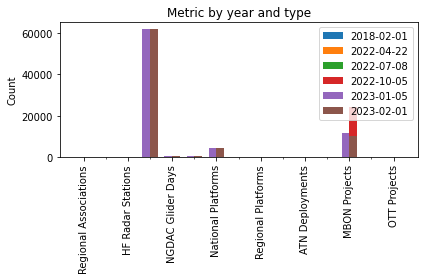

In [37]:
import matplotlib.pyplot as plt
import numpy as np

ioos_btn_df = ioos_btn_df.reset_index()

labels = ioos_btn_df.drop(columns=['date_UTC']).columns.tolist()

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()

for index, row in ioos_btn_df.iterrows():
  means = row.drop(index=['date_UTC']).values
  rects = ax.bar(x - width/2, means, width, label=row['date_UTC'].strftime('%Y-%m-%d'))
  width = width*-1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_title('Metric by year and type')
ax.set_xticks(x, labels)
ax.legend()

ax.xaxis.set_ticklabels(labels, rotation=90)

fig.tight_layout()

plt.show()

Plot percent increase.

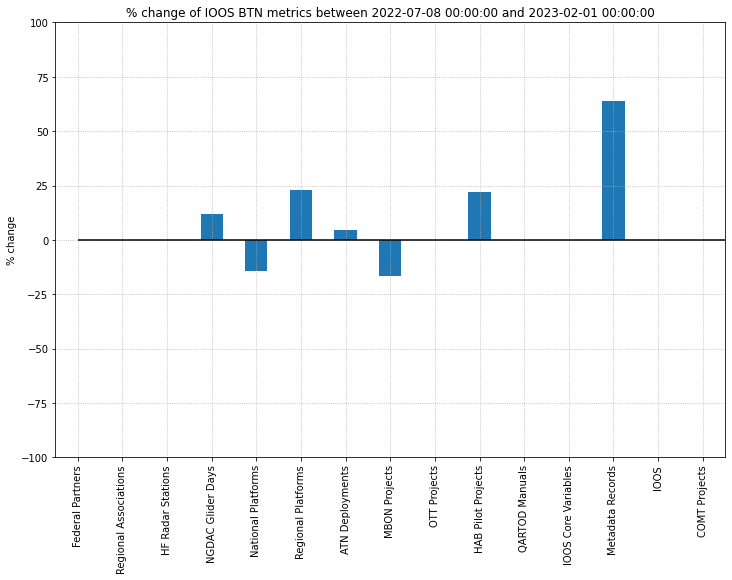

In [38]:
import matplotlib.pyplot as plt
import numpy as np

inc_df = ioos_btn_df.drop(columns=['date_UTC'])

increase = inc_df.iloc[-1] - inc_df.iloc[-4]

pcnt_increase = (increase / inc_df.iloc[-4]) * 100

fig, ax = plt.subplots(figsize=(12,8))
width = 0.35  # the width of the bars
pcnt_increase.plot(kind='bar', ax=ax, ylabel='% change')

plt.grid(visible=True, linestyle=':')
ax.set_ylim(-100,100)
plt.hlines(0,xmin=0,xmax=len(pcnt_increase),linestyles='solid')

ax.set_title('% change of IOOS BTN metrics between {} and {}'.format(ioos_btn_df['date_UTC'].iloc[-4],ioos_btn_df['date_UTC'].iloc[-1]))

plt.show()

In [39]:
pcnt_increase

Federal Partners          0.000000
Regional Associations     0.000000
HF Radar Stations         0.000000
NGDAC Glider Days        11.798442
National Platforms      -14.136126
Regional Platforms       22.823985
ATN Deployments           4.387939
MBON Projects           -16.666667
OTT Projects              0.000000
HAB Pilot Projects       22.222222
QARTOD Manuals            0.000000
IOOS Core Variables       0.000000
Metadata Records         63.696317
IOOS                      0.000000
COMT Projects             0.000000
dtype: float64